<a href="https://colab.research.google.com/github/k4west/huggingface/blob/main/Week15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transformer 모델과 🤗Transformers 소개  
##🤗로 시작하는 AI 스터디 Week 15
##학습범위: 대규모 데이터셋 수집하기 Chapter 10

발표자: 박현상

*발표자료와 실습자료를 이 문서로 통합

# 10.1 대규모 데이터셋 수집하기

## 10.1.1 대규모 말뭉치 구축의 어려움

대규모 데이터셋이 대부분 고도의 자동화로 만들어진다는 점이 몇가지 문제를 일으킵니다.내용과 생성 방법을 제어하기 어려워서 편한되고 품질 낮은 데이터에서 모델을 훈련할 위험이 증가합니다. BERT와 T5를 훈련하기 위해 각각 사용한 BookCorpus와 C4같은 유명한 대규모 데이터셋에서 밝혀진 사실은 다음과 같습니다.
* C4 말뭉치의 상당 부분을 사람이 아닌 기계가 번역했습니다.
* C4의 불용어 필터링으로 아프리카계 미국인의 영어가 이질적으로 삭제되었습니다.
* 대규모 텍스트 말뭉치는 성과 젠더를 언급한 부분을 완전히 삭제합니다. 이로인해 중립적이고 명시적인 의미로 쓰이기도 하는 'sex'같은 평범한 단어가 말뭉치에 전혀 등장하지 않아서 C4로 훈련한 토크나이저는 이 단어를 알지 못합니다.
* BookCorpus는 저작권을위반하는 내용이 많습니다. 다른 대규모 데이터셋도 마찬가지입니다.
* BookCorpus는 로맨스 소설 장르에 편향됐습니다.

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.3 MB/s eta 0:00:00


* GPT는 대부분 BookCorpus에서 훈련하고, GPT-2는 웹페이지, 블로그, 레딧에 링크된 뉴스 기사에서 훈련했습니다.

In [ ]:
from transformers import pipeline, set_seed
generation_gpt = pipeline("text-generation", model="openai-gpt")
generation_gpt2 = pipeline("text-generation", model="gpt2")

In [ ]:
def model_size(model):
    return sum(t.numel() for t in model.parameters())

print(f"GPT  크기: {model_size(generation_gpt.model)/1000**2:.1f}개 파라미터")
print(f"GPT2 크기: {model_size(generation_gpt2.model)/1000**2:.1f}개 파라미터")

GPT  크기: 116.5개 파라미터
GPT2 크기: 124.4개 파라미터


In [ ]:
def enum_pipeline_ouputs(pipe, prompt, num_return_sequences):
    out = pipe(prompt, num_return_sequences=num_return_sequences,
               clean_up_tokenization_spaces=True)
    return "\n".join(f"{i+1}." + s["generated_text"] for i, s in enumerate(out))

In [ ]:
prompt = "\nWhen they came back"
print("GPT 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt, prompt, 3))
print("")
print("GPT-2 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt2, prompt, 3))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT 자동 완성:
1.
When they came back to it, the two of them headed off to the back of the shop to get the books they would need for the next lesson. 
 * * * 
 after his first class, jack spent the rest of his day out by
2.
When they came back he was alone again. he 'd found the right tool for getting back from his home by the time he 'd got to the house. 
 the next day he arrived back in town - and found three older men sitting in the kitchen
3.
When they came back to his house. the only other person was the one on the sofa. 
 chapter eighteen 
 the morning came quickly, except when the alarm went off. 
 they 'd both kept to their strict schedule. neither would ask for anything

GPT-2 자동 완성:
1.
When they came back, they were expecting the news that Donald had died, and so no one knew what to expect.

Even Trump himself was shocked:

I got my condolences from all the people that were here today, from the
2.
When they came back from the camp, the first thing they heard was that they had com

## 10.1.2 사용자 정의 코드 데이터셋 만들기

구글 빅쿼리로 데이터셋 만들기  
SELECT
    f.repo_name, f.path, c.copies, c.size, c.content, l.license
FROM
    `bigquery-public-data.github_repos.files` AS f
JOIN
    `bigquery-public-data.github_repos.contents` AS c
ON
    f.id = c.id
JOIN
    `bigquery-public-data.github_repos.licenses` as l
ON
    f.repo_name = l.repo_name
WHERE
    NOT c.binary
    AND ((F.path LIKE '%.py')
        AND (c.size BETWEEN 1024 and 1048575))

Google Cloud에서 결과를 다운로드하는 단계

1.결과를 Google Cloud로 내보내기  
1.1Google Cloud Storage(GCS)에 버킷과 폴더를 만듭니다.  
1.2JSON 내보내기 형식과 gzip 압축을 사용하여 내보내기 > GCS로 내보내기를 선택하여 테이블을 이 버킷으로 내보냅니다.  
2.gsutil을 사용하여 버킷을 로컬 머신에 다운로드합니다.  
2.1pip install gsutil로 gsutil을 설치합니다.
2.2Google 계정(gsutil config)으로 gsutil을 구성합니다.  
2.3머신에 버킷을 복사합니다.  


In [ ]:
# gsutil -m -o "GSUtil:parallel_process_count=1" cp -r gs://<name_of_bucket>

In [ ]:
# Hugging Face Hub에서 데이터 세트 다운로드
# git clone https://huggingface.co/datasets/transformersbook/codeparrot

### 10.1.3 대용량 데이터셋 가루기

## 메모리 매핑

컴퓨터 프로그래밍에서 사용되는 최적화 기법으로 제로-카피,제로-오버헤드가 있습니다.  
* 제로-카피(zere-copy) : 데이터를 복사하지 않고도 데이터를 전송할 수 있는 기법  
참조 사이트:
             https://developer.ibm.com/articles/j-zerocopy/
             https://soft.plusblog.co.kr/7
* 제로-오버헤드(zero-overhead) : 어떤 작업을 수행할 때 추가적인 비용이 들지 않도록 하는 기법  
참조 사이트 :
            https://johngrib.github.io/wiki/jargon/zero-overhead-principle/

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


책에 있는 데이터세트는 180GB의 디스크 공간이 필요한 데이터세트입니다.codeparrot로 로드가 안돼서 codeparrot/github-code 로드 했습니다. 코랩 프로사용해도 디스크 공간이 부족하네요... 스트리밍으로 진행하겠습니다.

In [ ]:
# from datasets import load_dataset, DownloadConfig

# download_config = DownloadConfig(delete_extracted=True)
# dataset = load_dataset("codeparrot/github-code", split="train",
#                        download_config=download_config)

In [ ]:
# import psutil, os

# print(f"데이터셋에 있는 파이썬 파일의 개수 : {len(dataset)}")
# ds_size = sum(os.stat(f["filename"]).st_size for f in dataset.cache_files)
# # os.stat.st_size is expressed in bytes, so we convert to GB
# print(f"데이터셋 크기 (캐시 파일) : {ds_size / 2**30:.2f} GB")
# # Process.memory_info is expressed in bytes, so we convert to MB
# print(f"메모리 사용량 : {psutil.Process(os.getpid()).memory_info().rss >> 20} MB")

허깅페이스에서 원격 데이터세트를 스트리밍하기

In [ ]:
from datasets import load_dataset
streamed_dataset = load_dataset('codeparrot/github-code', split="train", streaming=True)

In [ ]:
iterator = iter(streamed_dataset)
print(next(iterator))
# print(dataset[0] == next(iterator)) # 데이터셋을 로드 못해서 비교가 안됩니다.
# print(dataset[1] == next(iterator))

{'code': '\'use strict\';\n\nvar clear          = require(\'es5-ext/array/#/clear\')\n  , eIndexOf       = require(\'es5-ext/array/#/e-index-of\')\n  , setPrototypeOf = require(\'es5-ext/object/set-prototype-of\')\n  , callable       = require(\'es5-ext/object/valid-callable\')\n  , d              = require(\'d\')\n  , ee             = require(\'event-emitter\')\n  , Symbol         = require(\'es6-symbol\')\n  , iterator       = require(\'es6-iterator/valid-iterable\')\n  , forOf          = require(\'es6-iterator/for-of\')\n  , Iterator       = require(\'./lib/iterator\')\n  , isNative       = require(\'./is-native-implemented\')\n\n  , call = Function.prototype.call, defineProperty = Object.defineProperty\n  , SetPoly, getValues;\n\nmodule.exports = SetPoly = function (/*iterable*/) {\n\tvar iterable = arguments[0];\n\tif (!(this instanceof SetPoly)) return new SetPoly(iterable);\n\tif (this.__setData__ !== undefined) {\n\t\tthrow new TypeError(this + " cannot be reinitialized");\n\t}

In [ ]:
remote_dataset = load_dataset('transformersbook/codeparrot', split="train",
                              streaming=True)

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

In [ ]:
!huggingface-cli login
!git config --global credential.helper store


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-c

In [ ]:
!huggingface-cli repo create --type dataset codeparrot-train

git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create datasets/BONOBONO/codeparrot-train
Proceed? [Y/n] Y
403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6551ac7e-69f47df507b8c92371c22c3e;be9f8a4e-4f21-4b5d-b641-29f5b0260657)

You don't have the rights to create a dataset under this namespace
{"error":"You don't have the rights to create a dataset under this namespace"}


In [ ]:
!huggingface-cli repo create --type dataset codeparrot-valid

git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create datasets/bonobono612/codeparrot-valid
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/datasets/bonobono612/codeparrot-valid

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/datasets/bonobono612/codeparrot-valid



In [ ]:
!git clone https://huggingface.co/datasets/bonobono612/codeparrot-train
!git clone https://huggingface.co/datasets/bonobono612/codeparrot-valid

Cloning into 'codeparrot-train'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), 527 bytes | 527.00 KiB/s, done.
Cloning into 'codeparrot-valid'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), 527 bytes | 527.00 KiB/s, done.


In [ ]:
!cd codeparrot-train
!cp ../codeparrot/*.json.gz .
!rm ./file-000000000183.json.gz

cp: cannot stat '../codeparrot/*.json.gz': No such file or directory
rm: cannot remove './file-000000000183.json.gz': No such file or directory


In [ ]:
! git add .
! git commit -m "Adding dataset files"
! git push

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!cd ../codeparrot-valid
!cp ../codeparrot/file-000000000183.json.gz
!mv ./file-000000000183.json.gz ./file-000000000183_validation.json.gz
!git add .
!git commit -m "Adding dataset files"
!git push

/bin/bash: line 1: cd: ../codeparrot-valid: No such file or directory
cp: missing destination file operand after '../codeparrot/file-000000000183.json.gz'
Try 'cp --help' for more information.
mv: cannot stat './file-000000000183.json.gz': No such file or directory
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


## 10.2 토크나이저 구축하기

### 10.2.1 토크나이저 모델

토크나이저는 정규화, 사전 토큰화, 토크나이저 모델, 사후 처리 네 단계로 구성된 전처리 파이프라인입니다. BPE, WordPiece, 유니그램 같은 부분단어 토큰화 알고리즘을 사용합니다.  
* BPE는 기본단위(단일 문자)의 리스트로 시작해서 가장 자주 함께 등장한 기본 단위를합쳐 어휘사전에 추가하는 식으로 점진적으로 새 토큰을 만드는 과정을 거쳐 어휘사전을 만듭니다.  
* 유니그램은 말뭉치에 있는 모든 단어와 가능성이 있는 부분단어로 기본 어휘 사전을 구성합니다. 그다음 어휘사전의 목표 크기에 도달할 때까지 점진적으로 유용성이 떨어지는 토큰을 삭제하거나 분할해 더 작은 어휘 사전을 얻습니다.  
* WordPiece는 유니그램의 전신이며, 공식 구현은 구글에서 오픈소스로 공개한 적이 없습니다.

### 10.2.2 토크나이저 성능 측정하기
* 부분단어 생산력은 토큰화된 단어마다 생성되는 부분단어의 평균 개수를 계산합니다.  
* 연속단어의 비율은 말뭉치에서 적어도 두 개의 부분 토큰으로 분할된 토큰화된 단어의 비율입니다.  
* 토큰화된 말뭉치에서 알 수 없는 단어나 거의 사용되지 않는 토큰의 비율 같은 커버리지 측정값입니다.


### 10.2.3 파이썬 코드를 위한 토크나이저
* 파이썬 코드를 공백으로 나눠 공백이 제거되면 들여쓰기 정보가 모두 사라집니다. 파이썬에서 공백은 중요한 의미가 있습니다.

In [ ]:
from transformers import AutoTokenizer
def tok_list(tokenizer, string):
    input_ids = tokenizer(string, add_special_tokens=False)["input_ids"]
    return [tokenizer.decode(tok) for tok in input_ids]
tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base")
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base")

print(f'"sex"에 대한 T5 토큰 : {tok_list(tokenizer_T5,"sex")}')
print(f' "being"에 대한 CamemBERT 토큰 : {tok_list(tokenizer_camembert,"being")}')

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


"sex"에 대한 T5 토큰 : ['', 's', 'ex']
 "being"에 대한 CamemBERT 토큰 : ['be', 'ing']


In [ ]:
from transformers import AutoTokenizer

python_code = r"""def say_hello():
    print("Hello, World!")
# Print it
say_hello()
"""
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!"', ')', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


In [ ]:
print(tokenizer.backend_tokenizer.normalizer)

None


In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():', (13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello', (28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ċ', (43, 44)), ('#', (44, 45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('say', (55, 58)), ('_', (58, 59)), ('hello', (59, 64)), ('()', (64, 66)), ('Ċ', (66, 67))]


바이트 수준이란 표현은 이 토크나이저가 유니코드 문자가 아닌 바이트 단위로 동작함을 뜻합니다. 각 유니코드 문자는 문자에 따라 1에서 4바이트로 구성됩니다. 유니코드 알파벳에는 143,859개의 유니코드문자가 있지만 바이트 알파벳에는 256개만 있다는 것이 바이트의 장점입니다. 바이트를 사용하면 UTF-8로 구성된 어떤 문자열도 256개 값의 알파벳으로 구성된 더 긴 문자열로 표현할 수 있습니다.  
즉 256개 알파벳만 사용해 어떤 유니코드 문자열도 처리하는 모델이 생깁니다.

In [ ]:
a, e = u"a", u"€"
byte = ord(a.encode("utf-8"))
print(f'`{a}` is encoded as `{a.encode("utf-8")}` with a single byte: {byte}')
byte = [ord(chr(i)) for i in e.encode("utf-8")]
print(f'`{e}` is encoded as `{e.encode("utf-8")}` with three bytes: {byte}')

`a` is encoded as `b'a'` with a single byte: 97
`€` is encoded as `b'\xe2\x82\xac'` with three bytes: [226, 130, 172]


* 유니코드 문자는 어휘사전에 포함할 때 모델의 임베딩 층이 어휘사전의 토큰마다 벡터 하나를 할당하기 때문에 이 층은 매우 커집니다.  
* 바이트 경우 모델이 긴 입력을 처리해야하며 나누어진 바이트에서 유니코드 문자를 재구성하고 문자에서 단어를 재구성하는 데 많은 컴퓨팅 성능을 소모합니다.
* 절충안은 가장 자주 많이 등장한 바이트 조합으로 256개 단어 어휘를 확장해서 어휘사전을 중간 규모로 만드는 것입니다. 이것이 BPE 알고리즘이 수행하는 방식입니다. 예를들어 t와h가 매우 자주함께 등장하면 th를 어휘사전에 추가합니다.

#### 바이트-페어  
 인코딩은 데이터 압축법의 하나로, 가장 자주 등장하는 바이트의 쌍을 새로운 바이트로 치환하는 방식으로 데이터를 압축합니다. 예를 들어, 'aaabdaaabac’라는 문자열에서 가장 많이 등장하는 바이트의 쌍은 'aa’입니다. 이 'aa’라는 바이트의 쌍을 하나의 바이트인 'Z’로 치환하면 'ZabdZabac’라는 새로운 문자열이 됩니다. 이 과정을 반복하면서 데이터의 크기를 줄일 수 있습니다12
####바이트 수준 (byte-level)
 자연어 처리에서의 서브워드 분리 (subword segmentation) 알고리즘입니다. 서브워드 분리란 하나의 단어를 더 작은 단위의 의미있는 여러 서브워드들의 조합으로 구성된 경우가 많기 때문에, 하나의 단어를 여러 서브워드로 분리해서 단어를 인코딩하고 임베딩하는 작업입니다. 이를 통해 OOV (Out-Of-Vocabulary) 문제나 희귀 단어, 신조어와 같은 문제를 완화할 수 있습니다. 바이트 수준에서 텍스트를 표현하고 256 바이트 집합을 어휘로 사용하는 것이 바이트 수준의 기본 원리입니다. 예를 들어, 'lower’라는 단어는 ‘l’, ‘o’, ‘w’, ‘e’, 'r’라는 5개의 바이트로 분리될 수 있습니다. 이렇게 분리된 바이트들은 각각의 임베딩 벡터를 가지게 됩니다

 참조사이트 : https://wikidocs.net/22592

NLP에서 일반적인 BPE 알고리즘을 사용할 때 문제가 하나 있습니다. 이 알고리즘은 입력으로 바이트가 아니라 정제된 유니코드 문자열을 다루도록 설계되어 공백이나 제어문자가 아닌 일반적인 ASCII 문자를 받습니다.
처음 256개 바이트 유니코드 문자에는 제어 문자(줄바꿈, 탭, 그 외 화면에 출력되지 않는 문자 등)가 많이 있습니다. GPT-2 토크나이저는 256개 입력 바이트를 표준 BPE 알고리즘이 쉽게 처리하는 유니코드 문자열로 매핑합니다. 즉 256개 값을 출력 가능한 표준 유니코드 문자에 해당하는 유니코드 문자열로 매핑합니다.

In [ ]:
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

print(f'기본 어휘사전 크기: {len(base_vocab)}')
print(f'첫 번째 원소: `{base_vocab[0]}`, 마지막 원소: `{base_vocab[-1]}`')

Size of our base vocabulary: 256
First element: `!`, last element: `Ń`


In [ ]:
import pandas as pd
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

examples = [
    ['일반적인 문자', '`a` and `?`', f'{ord("a")} and {ord("?")}' , f'`{byte_to_unicode_map[ord("a")]}` and `{byte_to_unicode_map[ord("?")]}`'],
    ['출력되지 않는 제어 문자 (줄바꿈 carriage return)', '`U+000D`', f'13', f'`{byte_to_unicode_map[13]}`'],
    ['공백', '` `', f'{ord(" ")}', f'`{byte_to_unicode_map[ord(" ")]}`'],
    ['분리할 수 없는 공백', '`\xa0`', '160', f'`{byte_to_unicode_map[ord(chr(160))]}`'],
    ['줄바꿈(line feed)', '`\n`', '10', f'`{byte_to_unicode_map[ord(chr(10))]}`'],
]

pd.DataFrame(examples, columns = ['Description', 'Character', 'Bytes', 'Mapped bytes'])

,Description,Character,Bytes,Mapped bytes
0,Regular characters,`a` and `?`,97 and 63,`a` and `?`
1,Nonprintable control character (carriage return),`U+000D`,13,`č`
2,A space,` `,32,`Ġ`
3,A nonbreakable space,` `,160,`ł`
4,A newline character,`\n`,10,`Ċ`


줄바꿈은 Ċ로 매핑되고, 공백은 Ġ로 매핑됩니다.
* 연속된 공백이 보존됩니다.
* 연속된 공백은 단어 하나로 간주합니다.
* 단어 앞 공백은 후속 단어에 포함된 단어의 일부로 간주합니다.

In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():', (13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello', (28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ċ', (43, 44)), ('#', (44, 45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('say', (55, 58)), ('_', (58, 59)), ('hello', (59, 64)), ('()', (64, 66)), ('Ċ', (66, 67))]


### 10.2.4 토크나이저 훈련하기

In [ ]:
print(f"어휘사전의 크기: {len(tokenizer)}")

Size of the vocabulary: 50257


In [ ]:
print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!"', ')', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


In [ ]:
# tokens = sorted(tokenizer.vocab.items(), key=lambda x: len(x[0]), reverse=True)
# print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:8]])

In [ ]:
tokens = sorted(tokenizer.get_vocab().items(), key=lambda x: len(x[0]), reverse=True)

top_tokens = tokens[:8]
top_strings = [t[0] for t in top_tokens]
formatted_output = '\n'.join(top_strings)
print(formatted_output)


ÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤ
Ġ=================================================================
Ġ----------------------------------------------------------------
................................................................
----------------------------------------------------------------
ÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤ
________________________________________________________________


In [ ]:
# tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True)
# print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:12]])

In [ ]:
tokens = sorted(tokenizer.get_vocab().items(), key=lambda x: x[1], reverse=True)

top_tokens = tokens[:12]
top_strings = [t[0] for t in top_tokens]
formatted_output = '\n'.join(top_strings)
print(formatted_output)

<|endoftext|>
Ġgazed
Ġinformants
ĠCollider
Ġregress
ominated
Ġamplification
Compar
âĢ¦."
Ġ(/
Commission
ĠHitman


<|endoftext|>은 텍스트 시퀀스의 끝을 지정할 때 사용하는 특수토큰으로, BPE 어휘사전이 구축된 후 추가됩니다.

In [ ]:
from tqdm.auto import tqdm

length = 100000
dataset_name = 'transformersbook/codeparrot-train'
dataset = load_dataset(dataset_name, split="train", streaming=True)
iter_dataset = iter(dataset)

def batch_iterator(batch_size=10):
    for _ in tqdm(range(0, length, batch_size)):
        yield [next(iter_dataset)['content'] for _ in range(batch_size)]

new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(),
                                                  vocab_size=12500,
                                                  initial_alphabet=base_vocab)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# tokens = sorted(new_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False)
# print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[257:280]])

In [ ]:
tokens = sorted(new_tokenizer.get_vocab().items(), key=lambda x: x[1], reverse=False)

top_tokens = tokens[257:280]
top_strings = [t[0] for t in top_tokens]
print(top_strings)

['ĠĠ', 'ĠĠĠĠ', 'ĠĠĠ', 'ĠĠĠĠĠĠĠĠ', 'se', 'in', 'ĠĠĠĠĠĠĠ', 're', 'on', 'te', 'ĊĠĠĠĠĠĠĠ', 'ĊĠĠĠĠĠĠĠĠ', 'or', 'st', 'de', 'ĊĠĠĠ', 'th', 'le', 'Ġ=', 'lf', 'self', 'me', 'al']


In [ ]:
# print([f'{new_tokenizer.convert_tokens_to_string(t)}' for t,_ in tokens[-12:]])

In [ ]:
tokens = sorted(new_tokenizer.get_vocab().items(), key=lambda x: x[1])

top_tokens = tokens[-12:]
top_strings = [t[0] for t in top_tokens]
print(top_strings)

['Ġcapt', 'Ġembedded', 'Ġregarding', 'Bundle', '355', 'Ġrecv', 'Ġdmp', 'Ġvault', 'ĠMongo', 'Ġpossibly', 'implementation', 'Matches']


In [ ]:
print(new_tokenizer(python_code).tokens())

['def', 'Ġs', 'ay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',', 'ĠWor', 'ld', '!")', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 's', 'ay', '_', 'hello', '()', 'Ċ']


In [ ]:
import keyword

print(f'파이썬 전체 예약어 개수 : {len(keyword.kwlist)}')
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer.vocab:
        print(f'예약어 `{keyw}` 는 어휘사전에 없습니다.')

파이썬 전체 예약어 개수 : 35
예약어 `await` 는 어휘사전에 없습니다.
예약어 `finally` 는 어휘사전에 없습니다.
예약어 `nonlocal` 는 어휘사전에 없습니다.


In [ ]:
length = 200000
new_tokenizer_larger = tokenizer.train_new_from_iterator(batch_iterator(),
    vocab_size=32768, initial_alphabet=base_vocab)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
tokens = sorted(new_tokenizer.get_vocab().items(), key=lambda x: x[1],reverse=False)

top_tokens = tokens[-12:]
top_strings = [t[0] for t in top_tokens]
print(top_strings)

['Ġcapt', 'Ġembedded', 'Ġregarding', 'Bundle', '355', 'Ġrecv', 'Ġdmp', 'Ġvault', 'ĠMongo', 'Ġpossibly', 'implementation', 'Matches']


In [ ]:
print(new_tokenizer_larger(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!")', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


In [ ]:
for keyw in keyword.kwlist:
    if keyw not in new_tokenizer_larger.vocab:
        print(f'예약어 `{keyw}` 는 어휘사전에 없습니다.')

예약어 `nonlocal` 는 어휘사전에 없습니다.


### 10.2.5 허브에 사용자 정의 토크나이저 저장하기

In [ ]:
model_ckpt = "bonobono612/codeparrot"
new_tokenizer_larger.push_to_hub(model_ckpt)

CommitInfo(commit_url='https://huggingface.co/bonobono612/codeparrot/commit/b83d5c3a7cd4e19e8c794bd04982c4477a28cf0b', commit_message='Upload tokenizer', commit_description='', oid='b83d5c3a7cd4e19e8c794bd04982c4477a28cf0b', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
print(reloaded_tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'ĊĠĠĠ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!")', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


In [ ]:
new_tokenizer.push_to_hub(model_ckpt+ "-small-vocabulary")

CommitInfo(commit_url='https://huggingface.co/bonobono612/codeparrot-small-vocabulary/commit/903655c7021f7a7069642effd5b189ab63f3b533', commit_message='Upload tokenizer', commit_description='', oid='903655c7021f7a7069642effd5b189ab63f3b533', pr_url=None, pr_revision=None, pr_num=None)

## 10.3 밑바닥부터 모델을 훈련하기

### 말뭉치에 있는 예

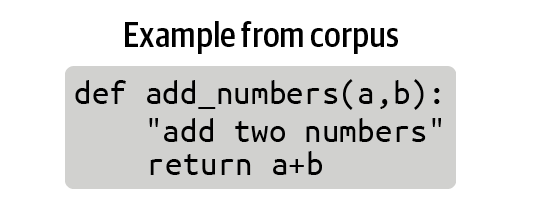

### 코잘 언어 모델링
* 마스킹된 미래 토큰을 예측합니다. 일반적으로 GPT 같은 디코더 모델을 사용합니다

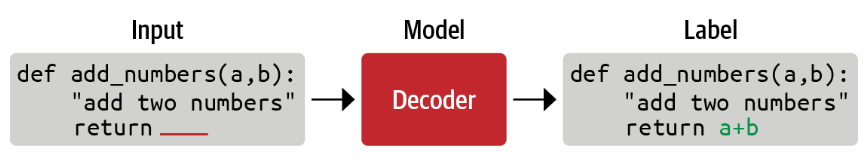

### 마스크드 언어 모델링
* 모델에게 잡음이 섞이 코드 샘플을 주고 깨끗한 원본 샘플을 재구성하라고 요청하는 것입니다. 잡음제거 목표(denoising objective)라고도 합니다.

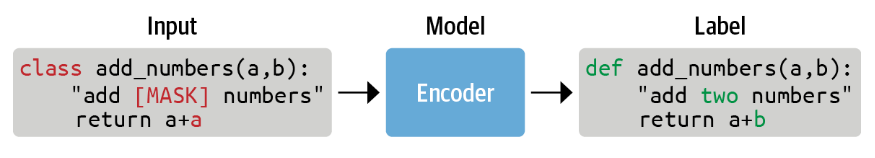

### 시퀀스-투-시퀀스 훈련
* 입력/출력을 어떻게 지정 하느냐에 따라 코드로부터 문서를 생성하거나 문서로부터 코드를 생성하는 일입니다. T5,BART,PEGASUS 같은 인코더-디코더 모델이 여기에 잘 맞습니다.

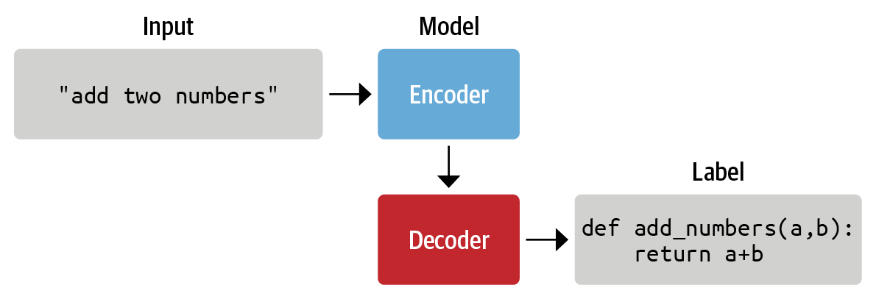

### 10.3.2 모델 초기화

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained("gpt2-xl", vocab_size=len(tokenizer))
model = AutoModelForCausalLM.from_config(config)

In [ ]:
print(f'GPT-2 (xl) 크기: {model_size(model)/1000**2:.1f}M 개의 파라미터')

GPT-2 (xl) 크기: 1529.6M 개의 파라미터


In [ ]:
model.save_pretrained("models/" + model_ckpt, push_to_hub=True)

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config_small = AutoConfig.from_pretrained("gpt2", vocab_size=len(tokenizer))
model_small = AutoModelForCausalLM.from_config(config_small)
print(f'GPT-2 크기: {model_size(model_small)/1000**2:.1f}개의 파라미터')

GPT-2 크기: 111.0개의 파라미터


### 10.3.3 데이터로더 구축하기

In [ ]:
model_small.save_pretrained("models/" +model_ckpt + "-small", push_to_hub=True)

model.safetensors:   0%|          | 0.00/444M [00:00<?, ?B/s]

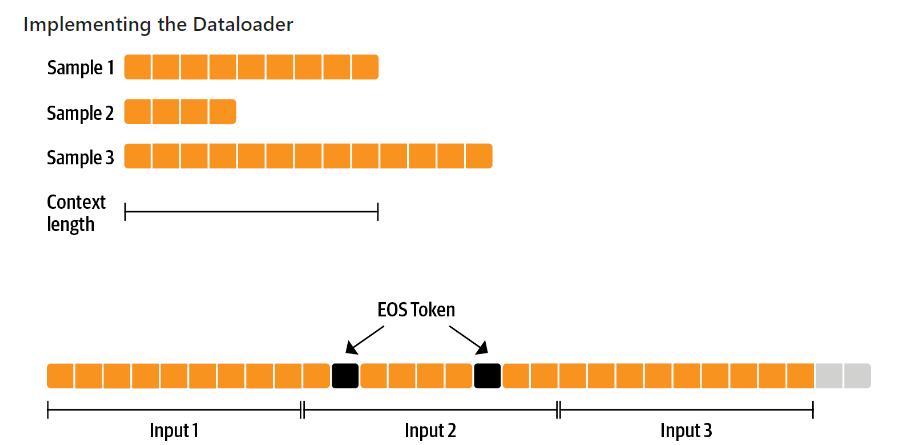

In [ ]:
examples, total_characters, total_tokens = 500, 0, 0
dataset = load_dataset('transformersbook/codeparrot-train', split='train',
                       streaming=True)

for _, example in tqdm(zip(range(examples), iter(dataset)), total=examples):
    total_characters += len(example['content'])
    total_tokens += len(tokenizer(example['content']).tokens())

characters_per_token = total_characters / total_tokens

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

토큰의 평균 문자 길이

In [ ]:
print(characters_per_token)

3.6231516195736053


In [ ]:
import torch
from torch.utils.data import IterableDataset

class ConstantLengthDataset(IterableDataset):

    def __init__(self, tokenizer, dataset, seq_length=1024,
                 num_of_sequences=1024, chars_per_token=3.6):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.eos_token_id
        self.dataset = dataset
        self.seq_length = seq_length
        self.input_characters = seq_length * chars_per_token * num_of_sequences

    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.input_characters:
                    m=f"버퍼 채우는 중: {buffer_len}>={self.input_characters:.0f}"
                    print(m)
                    break
                try:
                    m=f"버퍼 채우기 완료: {buffer_len}<{self.input_characters:.0f}"
                    print(m)
                    buffer.append(next(iterator)["content"])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    iterator = iter(self.dataset)

            all_token_ids = []
            tokenized_inputs = self.tokenizer(buffer, truncation=False)
            for tokenized_input in tokenized_inputs['input_ids']:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])

            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    yield torch.tensor(input_ids)


In [ ]:
shuffled_dataset = dataset.shuffle(buffer_size=100)
constant_length_dataset = ConstantLengthDataset(tokenizer, shuffled_dataset,
                                                num_of_sequences=10)
dataset_iterator = iter(constant_length_dataset)

lengths = [len(b) for _, b in zip(range(5), dataset_iterator)]
print(f"시퀀스 길이: {lengths}")

버퍼 채우기 완료: 0<36864
버퍼 채우기 완료: 14196<36864
버퍼 채우기 완료: 20459<36864
버퍼 채우기 완료: 23234<36864
버퍼 채우기 완료: 25507<36864
버퍼 채우기 완료: 28106<36864
버퍼 채우기 완료: 29732<36864
버퍼 채우는 중: 169521>=36864
시퀀스 길이: [1024, 1024, 1024, 1024, 1024]


### 10.3.4 훈련 루프 정의하기

In [ ]:
!pip install Accelerator

In [ ]:
import torch
import torch.nn.functional as F
from datasets import load_dataset
from accelerate import Accelerator

accelerator = Accelerator()
# - device = 'cpu'
device = accelerator.device

model = torch.nn.Transformer().to(device)
optim = torch.optim.Adam(model.parameters())

dataset = load_dataset('bonobono612/codeparrot')
data = torch.utils.data.DataLoader(dataset, shuffle=True)

model, optim, data = accelerator.prepare(model, optim, data)

model.train()
for epoch in range(10):
    for source, targets in data:
        source = source.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        output = model(source)
        loss = F.cross_entropy(output, targets)

# -         loss.backward()
        accelerator.backward(loss)

        optimizer.step()

In [ ]:
from argparse import Namespace

# Commented parameters correspond to the small model
config = {"train_batch_size": 2, # 12
          "valid_batch_size": 2, # 12
          "weight_decay": 0.1,
          "shuffle_buffer": 1000,
          "learning_rate": 2e-4, # 5e-4
          "lr_scheduler_type": "cosine",
          "num_warmup_steps": 750, # 2000
          "gradient_accumulation_steps": 16, # 1
          "max_train_steps": 50000, # 150000
          "max_eval_steps": -1,
          "seq_length": 1024,
          "seed": 1,
          "save_checkpoint_steps": 50000} # 15000

args = Namespace(**config)

In [ ]:
! pip install wandb

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import logging
import wandb

def setup_logging(project_name):
    logger = logging.getLogger(__name__)
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S", level=logging.INFO, handlers=[
        logging.FileHandler(f"log/debug_{accelerator.process_index}.log"),
        logging.StreamHandler()])
    if accelerator.is_main_process: # 로깅을 한 번만 설정합니다.
        wandb.init(project=project_name, config=args)
        run_name = wandb.run.name
        tb_writer = SummaryWriter()
        tb_writer.add_hparams(vars(args), {'0': 0})
        logger.setLevel(logging.INFO)
        datasets.utils.logging.set_verbosity_debug()
        transformers.utils.logging.set_verbosity_info()
    else:
        tb_writer = None
        run_name = ''
        logger.setLevel(logging.ERROR)
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    return logger, tb_writer, run_name


In [ ]:
def log_metrics(step, metrics):
    logger.info(f"Step {step}: {metrics}")
    if accelerator.is_main_process:
        wandb.log(metrics)
        [tb_writer.add_scalar(k, v, step) for k, v in metrics.items()]

In [ ]:
from torch.utils.data.dataloader import DataLoader

def create_dataloaders(dataset_name):
    train_data = load_dataset(dataset_name+'-train', split="train",
                              streaming=True)
    train_data = train_data.shuffle(buffer_size=args.shuffle_buffer,
                                    seed=args.seed)
    valid_data = load_dataset(dataset_name+'-valid', split="validation",
                              streaming=True)

    train_dataset = ConstantLengthDataset(tokenizer, train_data,
                                          seq_length=args.seq_length)
    valid_dataset = ConstantLengthDataset(tokenizer, valid_data,
                                          seq_length=args.seq_length)

    train_dataloader=DataLoader(train_dataset, batch_size=args.train_batch_size)
    eval_dataloader=DataLoader(valid_dataset, batch_size=args.valid_batch_size)
    return train_dataloader, eval_dataloader

In [ ]:
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [{'params': params_with_wd, 'weight_decay': args.weight_decay},
            {'params': params_without_wd, 'weight_decay': 0.0}]

In [ ]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch, labels=batch)
        loss = outputs.loss.repeat(args.valid_batch_size)
        losses.append(accelerator.gather(loss))
        if args.max_eval_steps > 0 and step >= args.max_eval_steps:
            break
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = torch.tensor(float("inf"))
    return loss.item(), perplexity.item()


In [ ]:
# 로깅 설정
logger, tb_writer, run_name = setup_logging(project_name.split("/")[1])
logger.info(accelerator.state)

# 모델 및 토크나이저 로드
if accelerator.is_main_process:
    hf_repo = Repository("./", clone_from=project_name, revision=run_name)
model = AutoModelForCausalLM.from_pretrained("./", gradient_checkpointing=True)
tokenizer = AutoTokenizer.from_pretrained("./")

# 데이터셋 및 데이터로더 로드
train_dataloader, eval_dataloader = create_dataloaders(dataset_name)

# 옵티마이저 및 학습률 스케줄러 설정
optimizer = AdamW(get_grouped_params(model), lr=args.learning_rate)
lr_scheduler = get_scheduler(name=args.lr_scheduler_type, optimizer=optimizer,
                             num_warmup_steps=args.num_warmup_steps,
                             num_training_steps=args.max_train_steps,)

def get_lr():
    return optimizer.param_groups[0]['lr']

# `accelerator`를 사용하여 모든 것을 준비 (인자의 순서는 중요하지 않음)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader)

# 모델 학습
model.train()
completed_steps = 0
for step, batch in enumerate(train_dataloader, start=1):
    loss = model(batch, labels=batch).loss
    log_metrics(step, {'lr': get_lr(), 'samples': step*samples_per_step,
                       'steps': completed_steps, 'loss/train': loss.item()})
    loss = loss / args.gradient_accumulation_steps
    accelerator.backward(loss)
    if step % args.gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    if step % args.save_checkpoint_steps == 0:
        logger.info('평가 및 모델 체크포인트 저장 중')
        eval_loss, perplexity = evaluate()
        log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        if accelerator.is_main_process:
            unwrapped_model.save_pretrained("./")
            hf_repo.push_to_hub(commit_message=f'스텝 {step}')
        model.train()
    if completed_steps >= args.max_train_steps:
        break

# 마지막 체크포인트 평가 및 저장
logger.info('평가 및 모델 학습 후 마지막 체크포인트 저장 중')
eval_loss, perplexity = evaluate()
log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
if accelerator.is_main_process:
    unwrapped_model.save_pretrained("./")
    hf_repo.push_to_hub(commit_message=f'최종 모델')

#### 모델저장  
wandb에서 얻은 run_name을 따라 새 브랜치를 체크아웃합니다. 나중에 체크초인트마다 모델을 커밋하고 허브에 푸시합니다. 실험할 때마다 새 브랜치가 만들어지고 각 커밋은 모델 체크포인트에 해당합니다.

#### 최적화  
코사인 학습률 스케줄러와 함께 AdamW를 사용합니다. 하이퍼파라미터의 경우 GPT-3논문에 기술된 비슷한 크기의 모델에서 사용한 파라미터와 비슷하게 설정합니다

#### 평가
모델을 저장할 때마다 평가 세트에서 평가합니다. 즉, 각 save_checkpoint_steps마다, 그리고 훈련이 끝난 후에 평가합니다. 검증 손실도 함께 검증 복잡도도 기록합니다.

#### 그레이디언트 누적과 체크포인팅
그레이디언트 체크포인팅이란 방법을 사용해 훈련 속도를 약20% 낮추면서 메모리 사용량을 줄일 수 있습니다. 이를 사용하면 더 큰 모델도 단일 GPU에서 훈련할 수 있습니다.

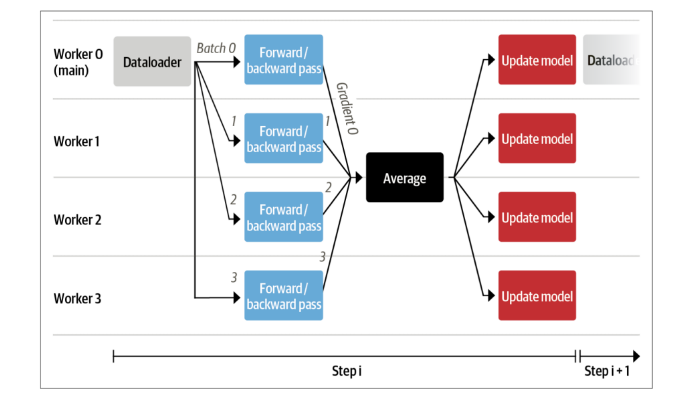

* 모델 병렬성 (Model Parallelism):

모델을 여러 부분으로 나누고, 각 부분을 별도의 GPU에 할당합니다.
이렇게 하면 모델이 메모리에 맞지 않을 때에도 대규모 모델을 훈련할 수 있습니다.
* 데이터 병렬성 (Data Parallelism):

데이터를 여러 개로 나누어 각 GPU에 전달합니다.
각 GPU는 자체의 미니배치에 대한 순전파 및 역전파를 계산합니다.
* 동기화 (Synchronization):

각 GPU에서 계산된 그래디언트(Gradient)들을 주기적으로 동기화하여 모든 GPU가 동일한 가중치를 유지합니다.
주로 AllReduce 알고리즘이 사용되어 각 GPU의 그래디언트를 모아 전체 모델에 대한 평균 그래디언트를 계산합니다.
* 분산 환경 설정:

네 개의 GPU가 서로 통신하고 동기화하기 위한 분산 환경을 설정해야 합니다.
대표적으로는 NVIDIA의 NCCL(NVIDIA Collective Communications Library)과 같은 라이브러리를 사용합니다.
* 손실 함수 및 최적화 알고리즘:

분산 환경에서는 손실 함수와 최적화 알고리즘을 여러 GPU에 맞게 조정해야 합니다.
특히 각 GPU에서 계산된 그래디언트를 어떻게 모을지, 평균할지 등을 결정해야 합니다.
* 분산 훈련 관리 (Distributed Training Management):

훈련의 시작과 종료, 중지 및 재개 등의 분산 훈련 관리 측면에서 적절한 도구나 라이브러리를 사용하여 네 개의 GPU 간의 효과적인 통신 및 협력이 이루어집니다.

### 10.3.5 훈련 실행

In [ ]:
!git clone https://huggingface.co/bonobono612/codeparrot
!cd codeparrot
!pip install -r requirements.txt
!wandb login
!accelerate config
!accelerate launch codparrot_training.py

Cloning into 'codeparrot'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (18/18), 719.67 KiB | 6.42 MiB/s, done.
Filtering content: 100% (2/2), 1.69 GiB | 12.01 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	model-00001-of-00002.safetensors

See: `git lfs help smudge` for more details.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
/bin/bash: line 1: wandb: command not found
/bin/bash: line 1: accelerate: command not found
/bin/bash: line 1: accelerate: command not found


In [ ]:
!git checkout main
!git merge <RUN_NAME>
!git push

## 10.4 결과 및 분석

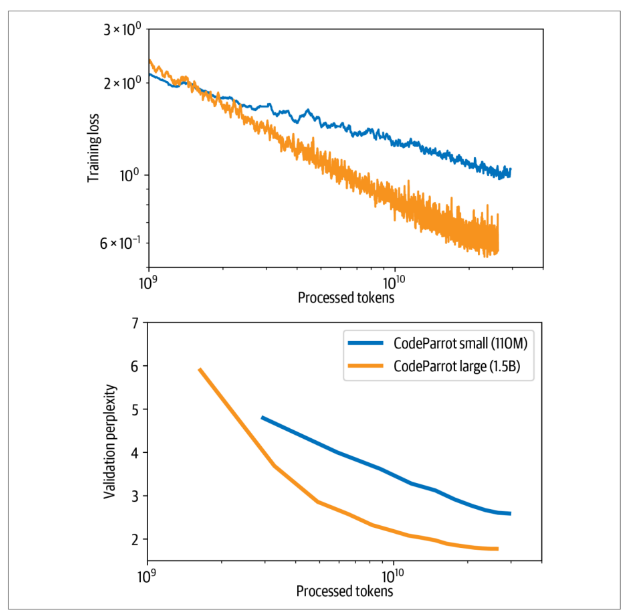

In [ ]:
from transformers import pipeline, set_seed

model_ckpt = 'transformersbook/codeparrot-small'
generation = pipeline('text-generation', model=model_ckpt, device=0)

In [ ]:
import re
from transformers import set_seed

def first_block(string):
    return re.split('\nclass|\ndef|\n#|\n@|\nprint|\nif', string)[0].rstrip()

def complete_code(pipe, prompt, max_length=64, num_completions=4, seed=1):
    set_seed(seed)
    gen_kwargs = {"temperature":0.4, "top_p":0.95, "top_k":0, "num_beams":1,
                  "do_sample":True,}
    code_gens = generation(prompt, num_return_sequences=num_completions,
                            max_length=max_length, **gen_kwargs)
    code_strings = []
    for code_gen in code_gens:
        generated_code = first_block(code_gen['generated_text'][len(prompt):])
        code_strings.append(generated_code)
    print(('\n'+'='*80 + '\n').join(code_strings))

In [ ]:
prompt = '''def area_of_rectangle(a: float, b: float):
    """Return the area of the rectangle."""'''
complete_code(generation, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return math.sqrt(a * b)

    return a * b / 2.0

    return a * b / 2.0

    return a * b / 2.0


In [ ]:
prompt = '''def get_urls_from_html(html):
    """Get all embedded URLs in a HTML string."""'''
complete_code(generation, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    if not html:
        return []
    return [url for url in re.findall(r'<a href="(/[^/]+/[^"]+?)">', html)]

    return [url for url in re.findall(r'<a href="(.*?)"', html)
            if url]

    return re.findall(r'<a href="(.*?)"', html)

    if not isinstance(html, basestring):
        html = str(html)

    url_list = []
    for i, url in enumerate(html.splitlines()):
        if not url.startswith('http


In [ ]:
import requests

def get_urls_from_html(html):
    return [url for url in re.findall(r'<a href="(.*?)"', html)if url]
print(" | ".join(get_urls_from_html(requests.get('https://hf.co/').text)))

/models | /spaces/ysharma/OpenAI_TTS_New | /spaces/HuggingFaceH4/open_llm_leaderboard | /spaces/FaceOnLive/Face-Recognition-SDK | /spaces/coqui/xtts | /spaces/jbilcke-hf/ai-comic-factory | /spaces | /datasets | /docs/transformers | /docs/diffusers | /docs/safetensors | /docs/huggingface_hub | /docs/tokenizers | /docs/peft | /docs/transformers.js | /docs/timm


In [ ]:
model_ckpt = 'transformersbook/codeparrot'
generation = pipeline('text-generation', model=model_ckpt, device=0)

prompt = '''# a function in native python:
def mean(a):
    return sum(a)/len(a)

# the same function using numpy:
import numpy as np
def mean(a):'''
complete_code(generation, prompt, max_length=64)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



    return np.mean(a)

    return sum(a)/len(a)

    return sum(a)/len(a)

    return sum(a)/len(a)


In [ ]:
prompt = '''X = np.random.randn(100, 100)
y = np.random.randint(0, 1, 100)

# fit random forest classifier with 20 estimators'''
complete_code(generation, prompt, max_length=96)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



reg = DummyRegressor()

forest = RandomForestClassifier(n_estimators=20)

forest.fit(X, y)

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X, y)

clf = RandomForestClassifier(n_estimators=20, n_jobs=n_jobs, random_state=1)
clf.fit(X, y)

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X, y)
